# nomic-ai
In this notebook we test each nomai-embed-text that are quantizated to 1 through 32 bits and check wich one is good for us.


first lets initialize or sentences for testing.

In [9]:
sentences = {
    0: "او به فروشگاه رفت تا نان بخرد",
    1: "این کتاب درباره تاریخ ایران است",
    2: "ماشین او خراب شد و نیاز به تعمیر داشت",
    3: "او در پارک قدم می‌زد و از هوا لذت می‌برد",
    4: "دیروز باران شدیدی بارید و خیابان‌ها را آب گرفت",
    5: "او به مدرسه می‌رود تا درس بخواند",
    6: "گربه روی دیوار نشسته بود",
    7: "امروز هوا بسیار گرم است",
    8: "دیشب ماه در آسمان روشن بود",
    9: "فردا با دوستانم به سفر می‌روم",
}

We use lm-studio and openAI package to connect to these models. you need to install nomic v1.5 models and run the server.

the above get_embedding function gives us the embedding and the time that elapsed to get that embedding

In [15]:
from openai import OpenAI
import time
client = OpenAI(base_url="http://localhost:1234/v1", api_key="lm-studio")

def get_embedding(text, model="nomic-ai/nomic-embed-text-v1.5-GGUF"):
    a = time.time()
    text = text.replace("\n", " ")
    embedding =  client.embeddings.create(input = [text], model=model).data[0].embedding
    b = time.time()
    return (embedding, b - a)

Now lets get the model names that we wants to test.

unfortunately we must change the embedding model in lm-studio after entering that names(lm studio doesn't support loading multiple embedding models)

In [18]:
import pandas as pd

embeddings = {}
times = {}

while True:
    quantization_model = input("Enter quantization name: ")
    if not quantization_model:
        break

    model_embeds = []
    model_times = []
    for key, value in sentences.items():
        embedding, elapsed_time = get_embedding(value)

        model_embeds.append(embedding)
        model_times.append(elapsed_time)
        
    embeddings[quantization_model] = model_embeds
    times[quantization_model] = model_times


Enter quantization name:  Q2_K
Enter quantization name:  Q3_K_S
Enter quantization name:  Q3_K_M
Enter quantization name:  Q3_K_L
Enter quantization name:  Q4_0
Enter quantization name:  Q4_K_S
Enter quantization name:  Q4_K_M
Enter quantization name:  Q5_0
Enter quantization name:  Q5_K_S
Enter quantization name:  Q5_K_M
Enter quantization name:  Q6_K
Enter quantization name:  Q8_0
Enter quantization name:  F16
Enter quantization name:  F32
Enter quantization name:  


In [25]:
embedding_df = pd.DataFrame(embeddings, index = list(sentences.keys()))
elapsed_time_df = pd.DataFrame(times, index = list(sentences.keys()))

In [34]:
elapsed_time_df.mean().sort_values().to_frame().rename({0: "Mean Elapsed Time"}, axis=1)

,Mean Elapsed Time
Q3_K_L,0.029835
Q4_0,0.031821
Q8_0,0.032037
Q2_K,0.033962
Q4_K_S,0.034132
Q5_K_S,0.034504
Q3_K_M,0.034645
Q3_K_S,0.034677
Q5_0,0.034804
Q4_K_M,0.035872


from the above df, we could say that even we have 2bits quantization is might take more time than even 8bits.

lets show the heatmap of sentences for each quantization

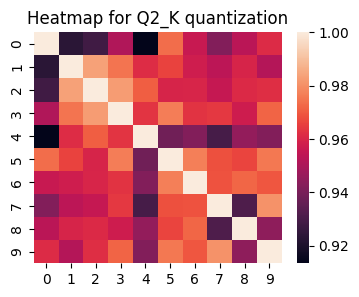

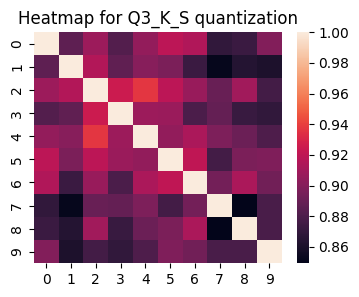

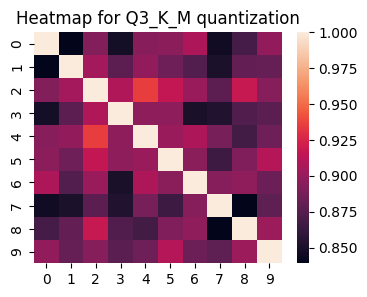

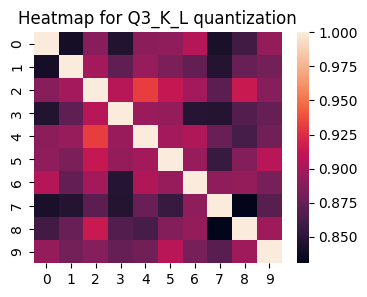

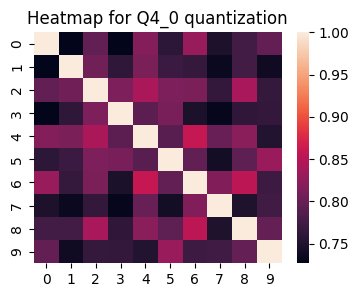

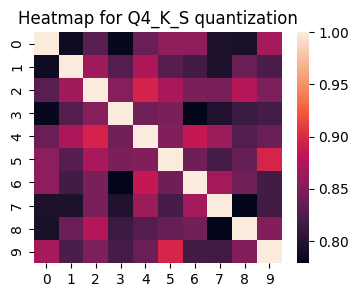

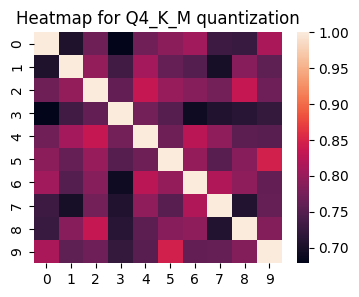

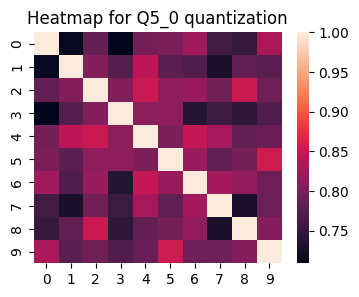

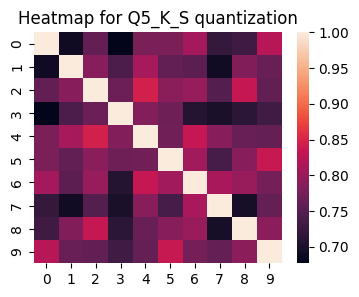

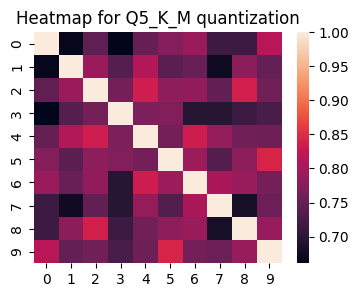

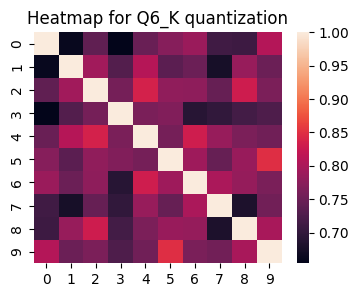

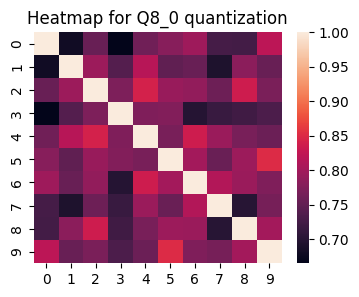

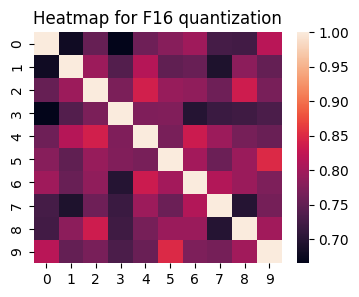

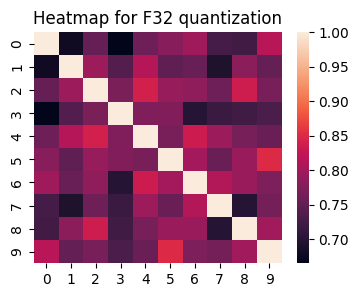

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt

for quantization in embedding_df.columns:
    pairwise_check = pd.DataFrame(index=embedding_df.index, columns=embedding_df.index)
    for col in embedding_df.index:
        for row in embedding_df.index:
            a = np.array([embedding_df[quantization][col]])
            b = np.array([embedding_df[quantization][row]])

            pairwise_check[col][row] = float(cosine_similarity(a,b)[0][0])
            
    pairwise_check = pairwise_check.map(pd.to_numeric)

    plt.figure(figsize=(4, 3))
    sns.heatmap(pairwise_check)
    plt.title(f"Heatmap for {quantization} quantization")
    plt.show()
